In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import soundfile as sf
from scipy.signal import resample_poly
import pandas as pd
import IPython.display as ipd
import time

AUDIO FILE INFORMATION:
----------------------------------------------------------------------
Sample Rate: 44100 Hz
Duration: 15.05 seconds
Total Samples: 663599
Audio Shape: (663599,)

Original Train Audio:


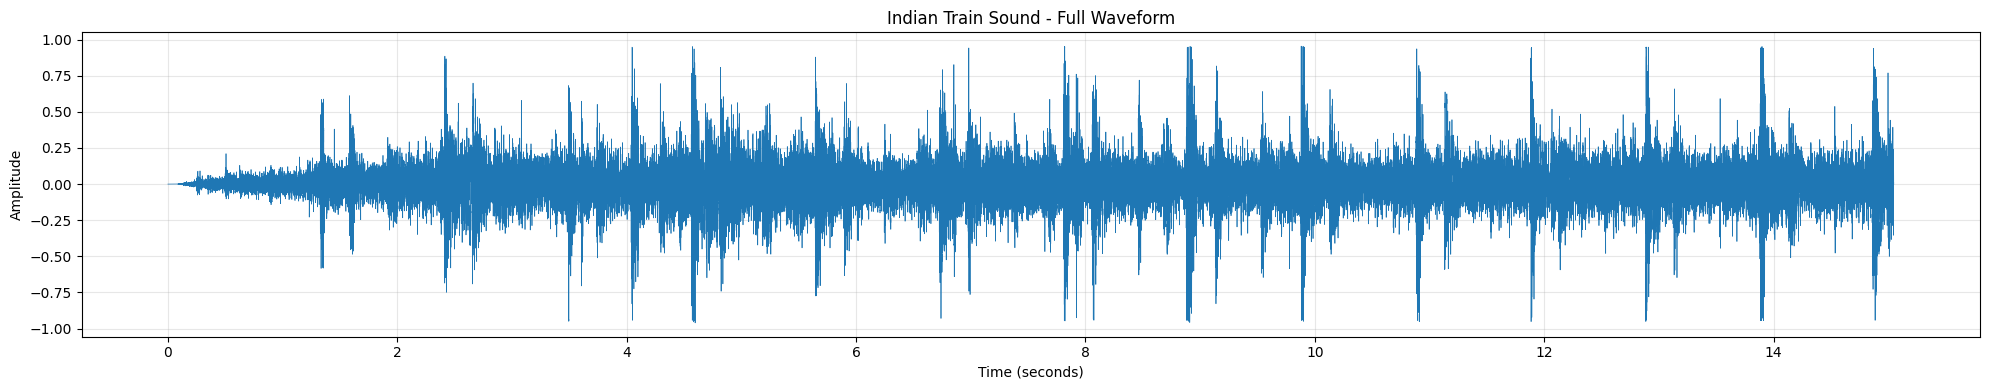

In [2]:
train_path = 'data/indian_train_sounds.mp3'
y_train, sr_train = librosa.load(train_path, sr=None)

print("AUDIO FILE INFORMATION:")
print("-" * 70)
print(f"Sample Rate: {sr_train} Hz")
print(f"Duration: {len(y_train)/sr_train:.2f} seconds")
print(f"Total Samples: {len(y_train)}")
print(f"Audio Shape: {y_train.shape}")
print()

# Play the audio
print("Original Train Audio:")
ipd.display(ipd.Audio(y_train, rate=sr_train))

# Visualize the full waveform
time_train = np.linspace(0, len(y_train)/sr_train, len(y_train))

plt.figure(figsize=(20, 4))
plt.plot(time_train, y_train, linewidth=0.5)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('Indian Train Sound - Full Waveform')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In this sound bite we have a periodic pattern (click-clack) of wheels over rail joints. It is noisy with many small fluctiations (from engine, wind, background etc.).

Convolution lets me filter or emphasize parts of this sound that matter to my goal.

**Algorithm**

1. Input: your 15 s audio of the train (normalize amplitude).

1. Choose a kernel:

    - Start with a moving average (e.g. 11 samples) to smooths small spikes.
    - Then try a derivative kernel [1, -1] to finds sharp transitions (clicks).

3. slide the kernel, multiply & sum.

4. Compare with existing library same kernel, same mode

5. Visualize and Quantify results

In [ ]:
# Day 10 — Convolution (1D) demo for the Indian-train-like audio
# This notebook cell:
# 1) Implements a classic time-domain 1D convolution from scratch
# 2) Applies two simple FIR filters (low-pass smoothing & first-difference)
# 3) Compares against NumPy's implementation
# 4) Visualizes and quantifies the effects
#
# If you have your own .wav file, set AUDIO_PATH to its path. Otherwise a synthetic
# "train-like" signal is generated (periodic impulses + noise).

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from numpy.fft import rfft, rfftfreq

# --------------- Config ---------------
AUDIO_PATH = "../data/indian_train_sounds.mp3"  # e.g., "/mnt/data/indian_train.wav"; if None, synthetic will be generated
TARGET_SECONDS = 15.0         # duration used/kept for demos
ZOOM_START_SEC = 7.5          # where to zoom in
ZOOM_WINDOW_SEC = 0.8
np.random.seed(7)

# --------------- Utilities ---------------
def normalize_audio(x):
    x = x.astype(np.float64)
    x = x - np.mean(x)
    max_abs = np.max(np.abs(x)) + 1e-12
    return x / max_abs

def pad_signal(x, M, mode="reflect"):
    """Pad so that output length equals input length ('same' behavior)."""
    left = (M - 1) // 2
    right = M - 1 - left
    return np.pad(x, (left, right), mode=mode)

def conv1d_naive(x, h, pad_mode="reflect"):
    """Classic O(NM) convolution producing 'same' length output.
       This performs true convolution (kernel flipped)."""
    x = np.asarray(x, dtype=np.float64)
    h = np.asarray(h, dtype=np.float64)
    M = len(h)
    xr = pad_signal(x, M, mode=pad_mode)
    hf = h[::-1]  # flip for convolution
    y = np.empty_like(x, dtype=np.float64)
    for n in range(len(x)):
        y[n] = np.dot(xr[n:n+M], hf)
    return y

def numpy_same_with_reflect(x, h):
    """Match the 'same' + reflect behavior using numpy.convolve (which has only valid/full/same).
       We'll manually pad (reflect), then use 'valid' with flipped kernel to emulate our function."""
    x = np.asarray(x, dtype=np.float64)
    h = np.asarray(h, dtype=np.float64)
    M = len(h)
    left = (M - 1)//2
    right = M - 1 - left
    xr = np.pad(x, (left, right), mode='reflect')
    # use valid, but remember numpy.convolve already flips the second arg for convolution math definition?
    # numpy.convolve implements correlation-like order (no explicit flip needed) yielding convolution
    # for our equivalence here, do not flip again.
    y_valid = np.convolve(xr, h, mode='valid')
    return y_valid

def spectral_centroid(x, fs):
    X = rfft(x)
    freqs = rfftfreq(len(x), 1/fs)
    mag = np.abs(X) + 1e-15
    return np.sum(freqs * mag) / np.sum(mag)

def band_energy(x, fs, f_lo, f_hi):
    X = rfft(x)
    freqs = rfftfreq(len(x), 1/fs)
    band = (freqs >= f_lo) & (freqs < f_hi)
    return np.sum(np.abs(X[band])**2) / (np.sum(band) + 1e-12)

# --------------- Load or synthesize signal ---------------
if AUDIO_PATH:
    fs, x = wavfile.read(AUDIO_PATH)
    if x.ndim == 2:
        x = np.mean(x, axis=1)
    x = normalize_audio(x)
    # trim or pad to TARGET_SECONDS
    N_target = int(TARGET_SECONDS * fs)
    if len(x) >= N_target:
        x = x[:N_target]
    else:
        x = np.pad(x, (0, N_target - len(x)))
else:
    # Synthetic "train-like": periodic impulse train + slowly varying amplitude + noise
    fs = 16000
    t = np.arange(int(TARGET_SECONDS*fs))/fs
    # periodic clicks around 3.0 Hz (~ every 0.33 s), with slight jitter
    click_rate = 3.0
    click_positions = np.cumsum(np.random.normal(1/click_rate, 0.02, size=int(click_rate*TARGET_SECONDS*1.4)))
    click_positions = click_positions[click_positions < TARGET_SECONDS]
    click_idx = (click_positions * fs).astype(int)
    x = np.zeros_like(t)
    # each click: short decaying pulse
    pulse_len = int(0.01 * fs)
    pulse = np.exp(-np.linspace(0, 5, pulse_len))
    for idx in click_idx:
        if idx + pulse_len < len(x):
            x[idx:idx+pulse_len] += pulse
    # add low-frequency engine-like hum + white noise
    x += 0.2*np.sin(2*np.pi*80*t) + 0.05*np.random.randn(len(t))
    x = normalize_audio(x)

# --------------- Define kernels ---------------
# (1) Moving average (low-pass)
LP_LEN = 11
h_lp = np.ones(LP_LEN, dtype=np.float64)/LP_LEN

# (2) First difference (high-pass / derivative-like)
h_diff = np.array([1.0, -1.0], dtype=np.float64)

# --------------- Apply our convolution ---------------
y_lp_me   = conv1d_naive(x, h_lp, pad_mode="reflect")
y_diff_me = conv1d_naive(x, h_diff, pad_mode="reflect")

# --------------- Compare with NumPy ---------------
y_lp_np   = numpy_same_with_reflect(x, h_lp)
y_diff_np = numpy_same_with_reflect(x, h_diff)

mse_lp   = np.mean((y_lp_me - y_lp_np)**2)
mse_diff = np.mean((y_diff_me - y_diff_np)**2)
maxerr_lp   = np.max(np.abs(y_lp_me - y_lp_np))
maxerr_diff = np.max(np.abs(y_diff_me - y_diff_np))

# --------------- Quantitative effects ---------------
rms_before  = np.sqrt(np.mean(x**2))
rms_lp      = np.sqrt(np.mean(y_lp_me**2))
rms_diff    = np.sqrt(np.mean(y_diff_me**2))

sc_before   = spectral_centroid(x, fs)
sc_lp       = spectral_centroid(y_lp_me, fs)
sc_diff     = spectral_centroid(y_diff_me, fs)

band_lo_before = band_energy(x, fs, 0, 300)
band_lo_lp     = band_energy(y_lp_me, fs, 0, 300)
band_lo_diff   = band_energy(y_diff_me, fs, 0, 300)

band_hi_before = band_energy(x, fs, 3000, fs/2)
band_hi_lp     = band_energy(y_lp_me, fs, 3000, fs/2)
band_hi_diff   = band_energy(y_diff_me, fs, 3000, fs/2)

# --------------- Plots (each chart in its own figure) ---------------
# 1) Full waveform & filtered
time = np.arange(len(x))/fs

plt.figure(figsize=(14,3))
plt.plot(time, x, linewidth=0.7)
plt.title("Original Signal (normalized)")
plt.xlabel("Time [s]"); plt.ylabel("Amplitude")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14,3))
plt.plot(time, y_lp_me, linewidth=0.7)
plt.title("After Low-pass (Moving Average)")
plt.xlabel("Time [s]"); plt.ylabel("Amplitude")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14,3))
plt.plot(time, y_diff_me, linewidth=0.7)
plt.title("After First-Difference (Onset Emphasis)")
plt.xlabel("Time [s]"); plt.ylabel("Amplitude change")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2) Zoomed window for visual comparison
i0 = int(ZOOM_START_SEC * fs)
i1 = int((ZOOM_START_SEC + ZOOM_WINDOW_SEC) * fs)

plt.figure(figsize=(14,3))
plt.plot(time[i0:i1], x[i0:i1], linewidth=1.2, label="Original")
plt.plot(time[i0:i1], y_lp_me[i0:i1], linewidth=1.0, label="Low-pass")
plt.legend()
plt.title("Zoom: Original vs Low-pass")
plt.xlabel("Time [s]"); plt.ylabel("Amplitude")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14,3))
plt.plot(time[i0:i1], x[i0:i1], linewidth=1.2, label="Original")
plt.plot(time[i0:i1], y_diff_me[i0:i1], linewidth=1.0, label="First-Diff")
plt.legend()
plt.title("Zoom: Original vs First-Difference")
plt.xlabel("Time [s]"); plt.ylabel("Amplitude / change")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3) Differences vs NumPy (should be near zero)
plt.figure(figsize=(14,3))
plt.plot(time, y_lp_me - y_lp_np, linewidth=0.7)
plt.title(f"Difference (Ours - NumPy) for Low-pass | MSE={mse_lp:.2e}, MaxErr={maxerr_lp:.2e}")
plt.xlabel("Time [s]"); plt.ylabel("Amplitude diff")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14,3))
plt.plot(time, y_diff_me - y_diff_np, linewidth=0.7)
plt.title(f"Difference (Ours - NumPy) for First-Diff | MSE={mse_diff:.2e}, MaxErr={maxerr_diff:.2e}")
plt.xlabel("Time [s]"); plt.ylabel("Amplitude diff")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 4) Bar charts of metrics (RMS and spectral centroid)
labels = ["Original", "Low-pass", "First-Diff"]
rms_vals = [rms_before, rms_lp, rms_diff]
sc_vals  = [sc_before, sc_lp, sc_diff]

plt.figure(figsize=(6,4))
plt.bar(labels, rms_vals)
plt.title("RMS (Energy) Before/After")
plt.ylabel("RMS")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.bar(labels, sc_vals)
plt.title("Spectral Centroid Before/After")
plt.ylabel("Centroid [Hz]")
plt.tight_layout()
plt.show()

# 5) Band energy comparison
lo_vals = [band_lo_before, band_lo_lp, band_lo_diff]
hi_vals = [band_hi_before, band_hi_lp, band_hi_diff]

plt.figure(figsize=(6,4))
plt.bar(labels, lo_vals)
plt.title("Low-band Energy (0–300 Hz)")
plt.ylabel("Energy (arb.)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.bar(labels, hi_vals)
plt.title("High-band Energy (3 kHz – Nyquist)")
plt.ylabel("Energy (arb.)")
plt.tight_layout()
plt.show()

# --------------- Print summary ---------------
print("=== Convolution vs NumPy (same+reflect) ===")
print(f"Low-pass  : MSE = {mse_lp:.3e} | Max |diff| = {maxerr_lp:.3e}")
print(f"First-Diff: MSE = {mse_diff:.3e} | Max |diff| = {maxerr_diff:.3e}")
print()
print("=== Before/After Metrics ===")
print(f"RMS        -> orig: {rms_before:.4f} | LP: {rms_lp:.4f} | Diff: {rms_diff:.4f}")
print(f"CentroidHz -> orig: {sc_before:.1f}   | LP: {sc_lp:.1f}  | Diff: {sc_diff:.1f}")
print(f"Low-band   -> orig: {band_lo_before:.3e} | LP: {band_lo_lp:.3e} | Diff: {band_lo_diff:.3e}")
print(f"High-band  -> orig: {band_hi_before:.3e} | LP: {band_hi_lp:.3e} | Diff: {band_hi_diff:.3e}")

# Save a couple of representative figures
plt.figure(figsize=(14,3))
plt.plot(time, x, linewidth=0.7, label="Original")
plt.plot(time, y_lp_me, linewidth=0.7, label="Low-pass")
plt.plot(time, y_diff_me, linewidth=0.7, label="First-Diff")
plt.legend()
plt.title("Overlay: Original vs Filtered")
plt.xlabel("Time [s]"); plt.ylabel("Amplitude / change")
plt.grid(True, alpha=0.3)
plt.tight_layout()
overlay_path = "/mnt/data/convolution_overlay.png"
plt.savefig(overlay_path, dpi=150)
plt.close()

print(f"\nSaved overlay figure: {overlay_path}")

    